# Plot layers by First Order Mutagenesis

You can use this notebook to visualize the sequences and the neurons you've selected from mining. Play around with the values of normfactor in the normfactorlists to get the best visuals for each layer for each model.

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

sys.path.append('..')
from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency, metrics
import helper
import mutagenesisfunctions as mf

np.random.seed(247)
tf.set_random_seed(247)

In [122]:
def fom_convsal(X, layer, alphabet, filter_index, max_idx, nntrainer, sess, title='notitle', figsize=(15,2)
                , fig=None, pos=None, idx=None):
    
    eps = 1e-7
    
    #first mutate the sequence
    X_mut = mf.mutate(X, X.shape[1], X.shape[3])

    #take all the mutations and assign them into a dict for deepomics
    mutations = {'inputs': X_mut, 'targets': np.ones((X_mut.shape[0], 1))}
    #Get the neurons score for the mutations
    mut_scores = nntrainer.get_activations(sess, mutations, layer=layer)[:, max_idx[filter_index], :, filter_index]

    #take the WT and put it into a dict for deepomics
    WT = {'inputs': X, 'targets': np.ones((X.shape[0], 1))}
    #Get activations for the WT sequence
    WT_score = nntrainer.get_activations(sess, WT, layer=layer)[:, max_idx[filter_index], :, filter_index]

    #shape the predictions of the mutations into the shape of a heatmap
    heat_mut = mut_scores.reshape(X.shape[1],4).T
    
    #normalize the heat map rearrangement by minusing it by the true prediction score of that test sequence
    #norm_heat_mut = (heat_mut - WT_score) + eps
    #norm_heat_mut = utils.normalize_pwm(norm_heat_mut, factor=4)

    return (heat_mut)

def add_normfactors(data, normfactorlist):
    copy = []
    for ii, layer in enumerate(data):
        layercopy = []
        for val in layer:   #copying lists is not robust so we have to go through this nonsense
            layercopy.append(val)
        layercopy.append(normfactorlist[ii])
        copy.append(layercopy)
    return (copy)


In [119]:
'''DISTNET'''
data_dist = {}

data_dist[2115] = [['conv1d_0_active', [10,17,12,4]],
                 ['conv1d_1_active', [19,17,28,10]],
                 ['conv1d_2_active', [46,44,6,11]],
                 ['conv1d_3_active', [7,49,47,42]],
                 ['conv1d_4_active', [49,55,25,54]]]



data_dist[4149]=[['conv1d_0_active', [23,2,8,20]],
                 ['conv1d_1_active', [8,12,31,17]],
                 ['conv1d_2_active', [18,31,3,44]],
                 ['conv1d_3_active', [9,48,55,32]],
                 ['conv1d_4_active', [53,51,89,77]]]



data_dist[1608]=[['conv1d_0_active', [1,22,21,20]],
                 ['conv1d_1_active', [27,12,22,28]],
                 ['conv1d_2_active', [1,44,11,20]],
                 ['conv1d_3_active', [42,62,10,29]],
                 ['conv1d_4_active', [60,5,19,13]]]    


'''LOCALNET'''

data_local={}

data_local[1608]=[['conv1d_0_active', [1,17,20,10]],
                 ['conv1d_1_active', [65,48,41,71]]]

data_local[4149]=[['conv1d_0_active', [2,4,22,23]],
                 ['conv1d_1_active', [38,80,8,51]]]

data_local[2115]=[['conv1d_0_active', [4,15,2,22]],
                 ['conv1d_1_active', [93,92,66,73]]]


In [2]:
data_path = '../data/Synthetic_dataset.h5'
results_path = '../results'
params_path = utils.make_directory(results_path, 'model_params')
plot_path = utils.make_directory(results_path, 'FoM_layers')

# load dataset
train, valid, test = helper.load_synthetic_dataset(data_path)

test_model = helper.load_synthetic_models(data_path, dataset='test')
    
# get data shapes
input_shape = list(train['inputs'].shape)
input_shape[0] = None
output_shape = [None, train['targets'].shape[1]]

loading training data
loading cross-validation data
loading test data


# Which sequence?

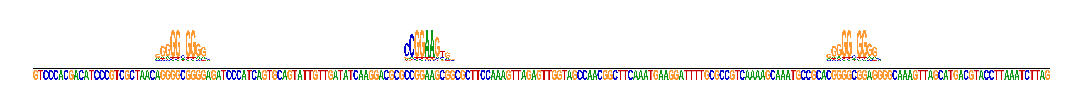

In [34]:
index = 4149
X = np.expand_dims(test['inputs'][index], axis=0)
X_model = test_model[index]


fig = plt.figure(figsize=(15,7))

visualize.plot_seq_pos_saliency(np.squeeze(X).T, X_model, alphabet='dna', nt_width=50, norm_factor=3)


output_name = 'modelsequence_' + str(index)
outfile = os.path.join(plot_path, output_name+'.pdf')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')

# DistNet

making directory: ../results/FoM_layers/DistNet/LocalNet/DistNet/LocalNet/DistNet/LocalNet/DistNet/LocalNet/LocalNet/DistNet/LocalNet/DistNet
loading model from:  ../results/model_params/DistNet/DistNet_do_l2_bn_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/model_params/DistNet/DistNet_do_l2_bn_best.ckpt


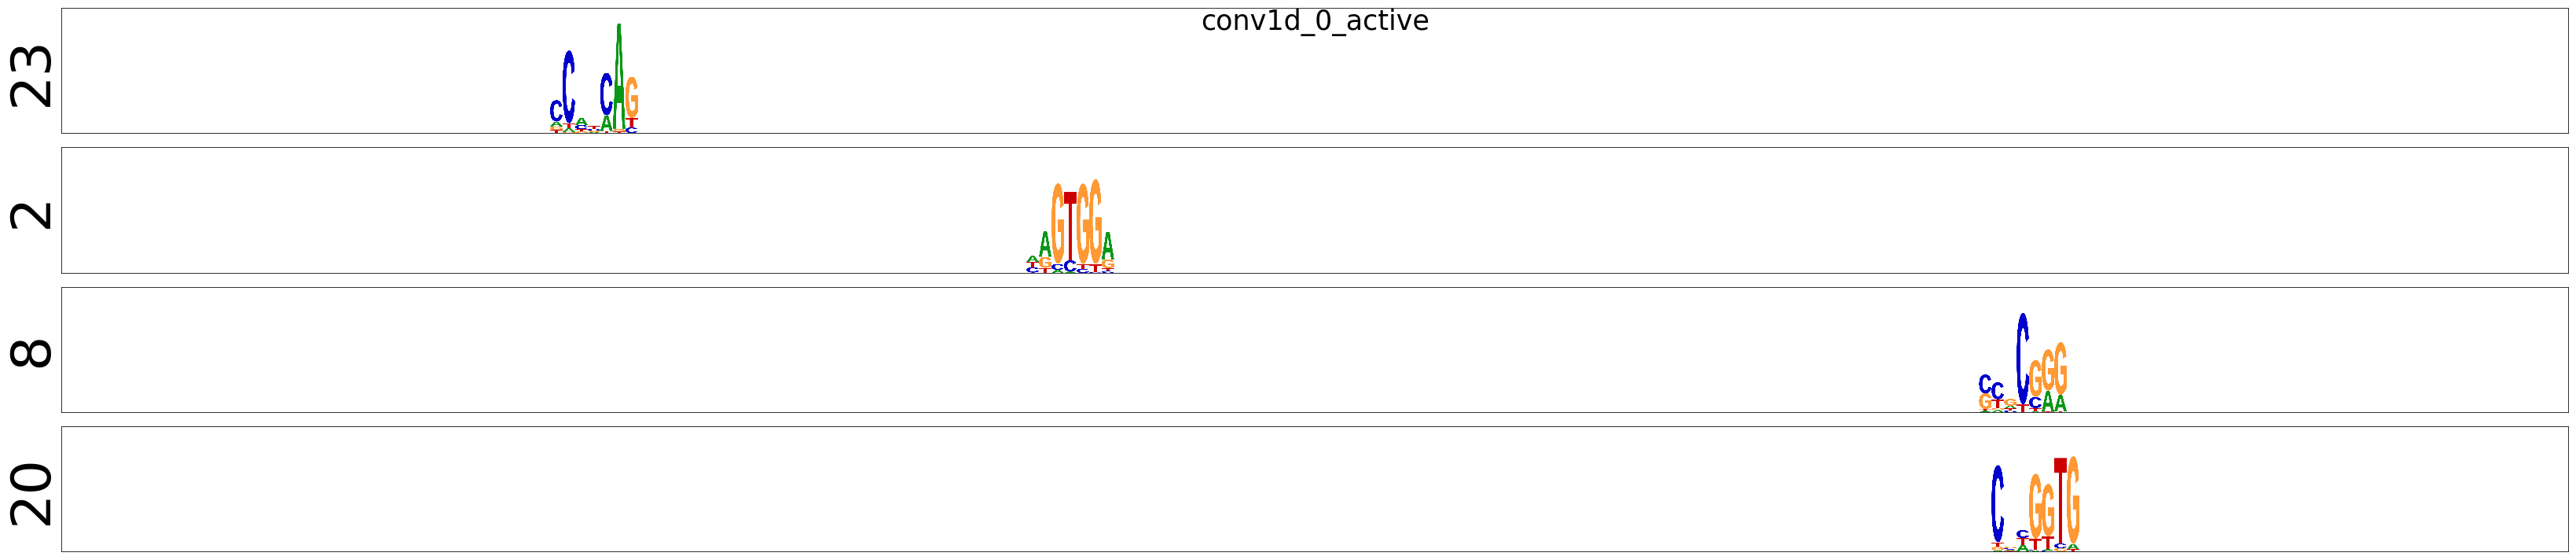

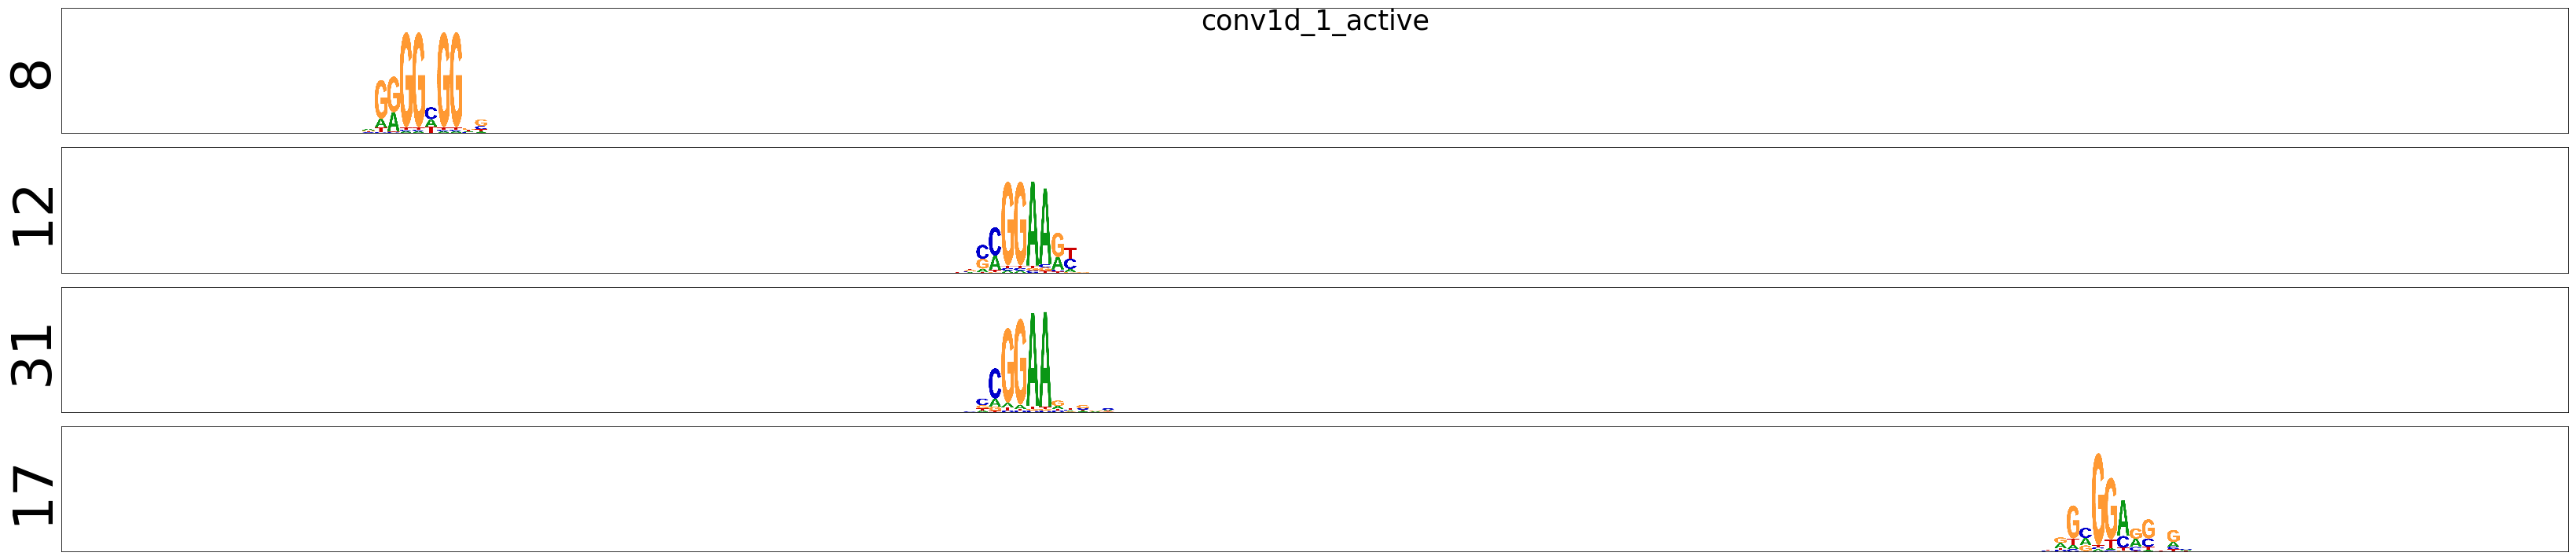

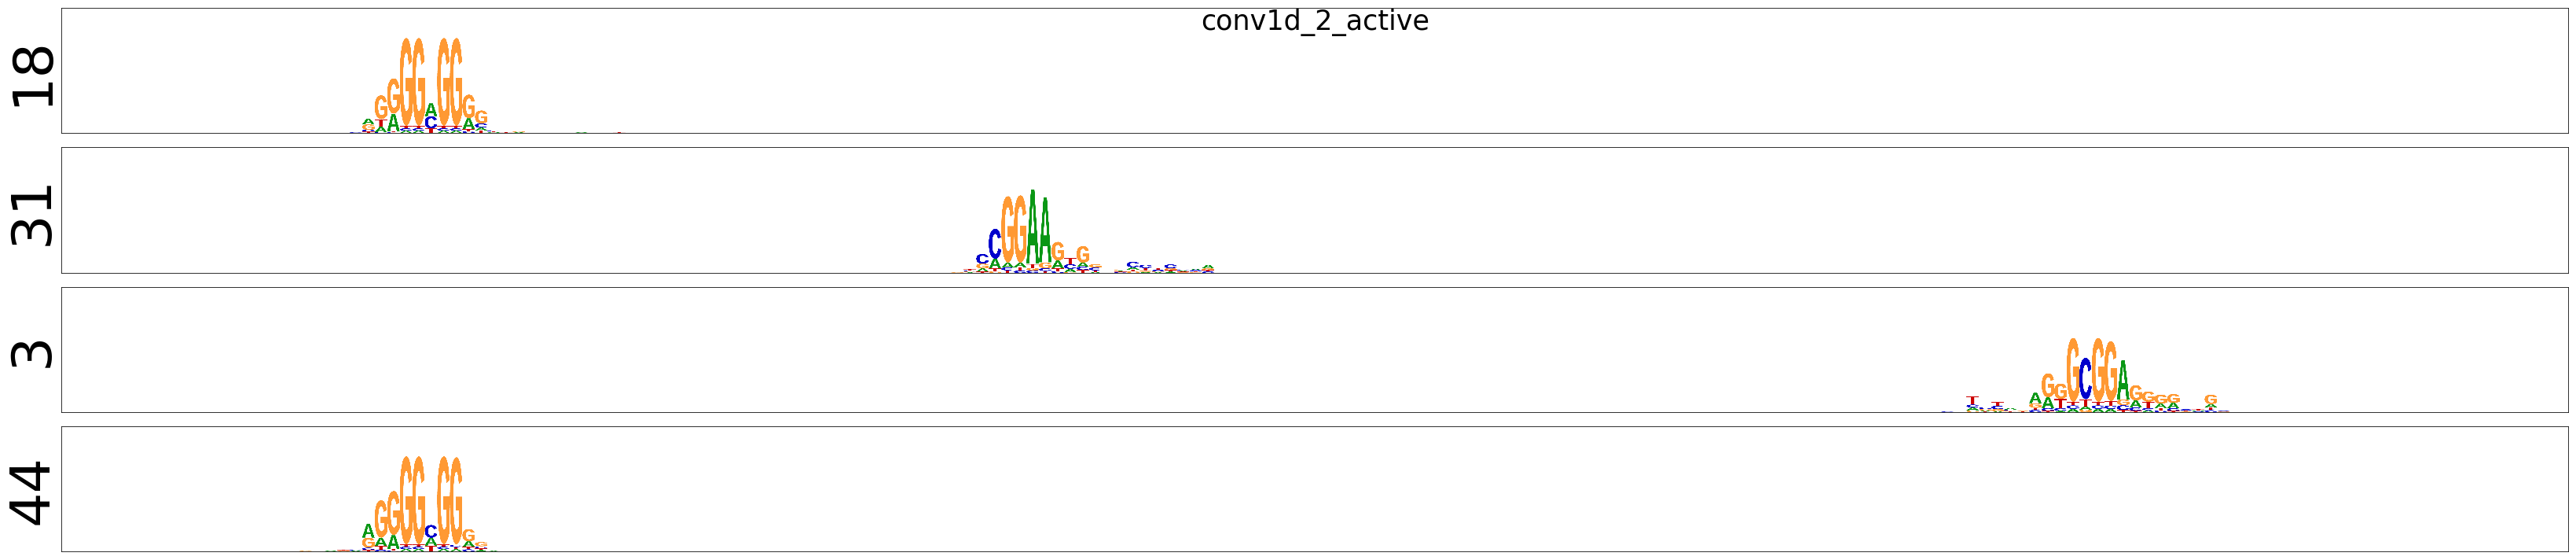

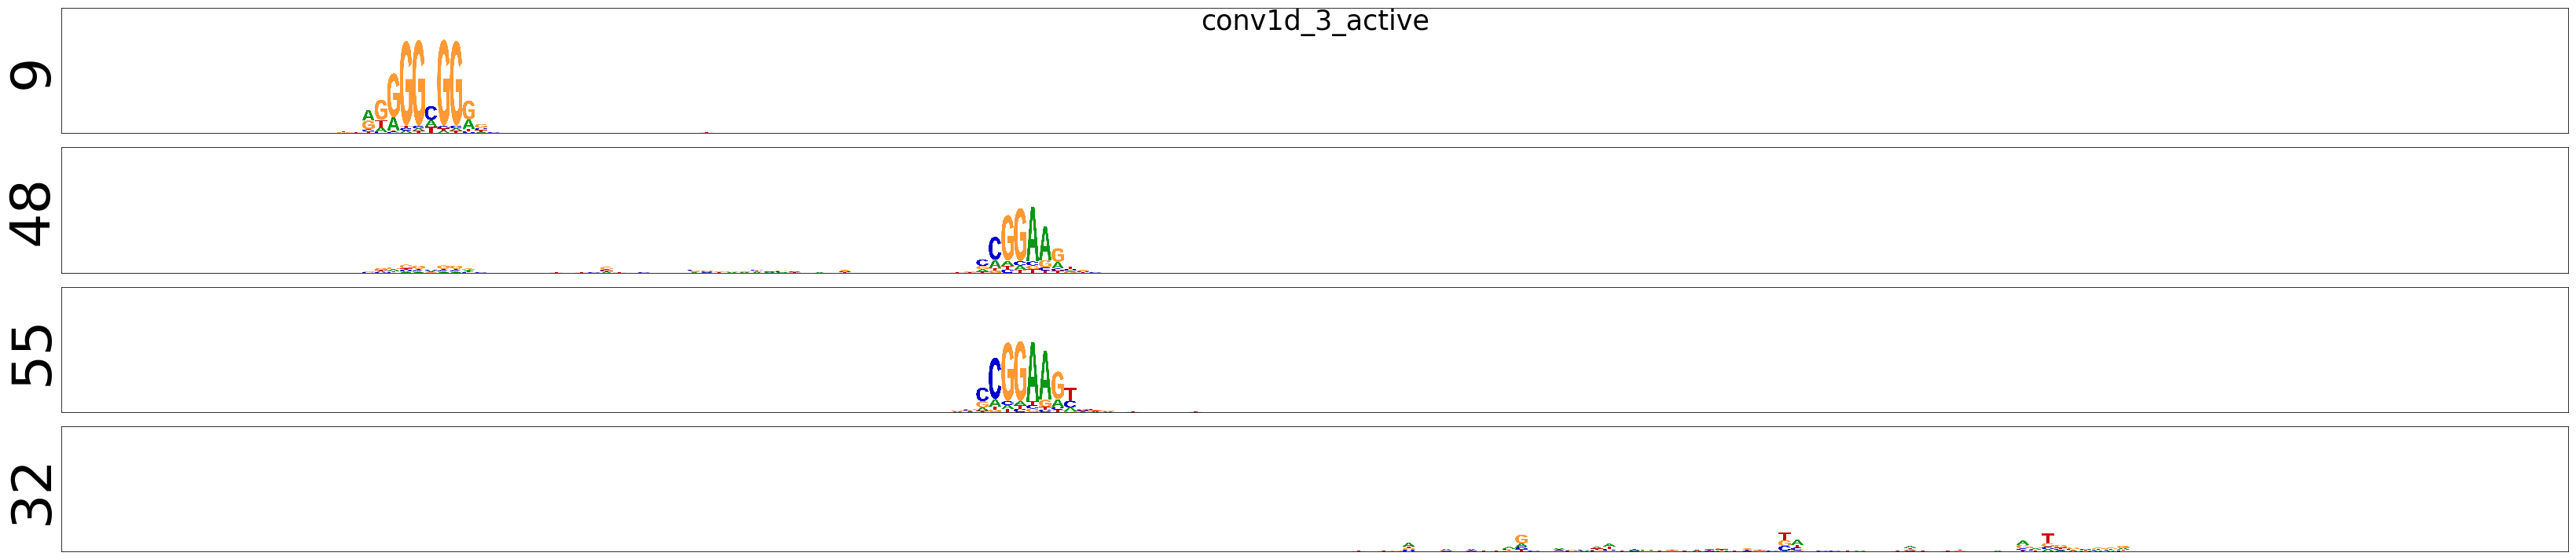

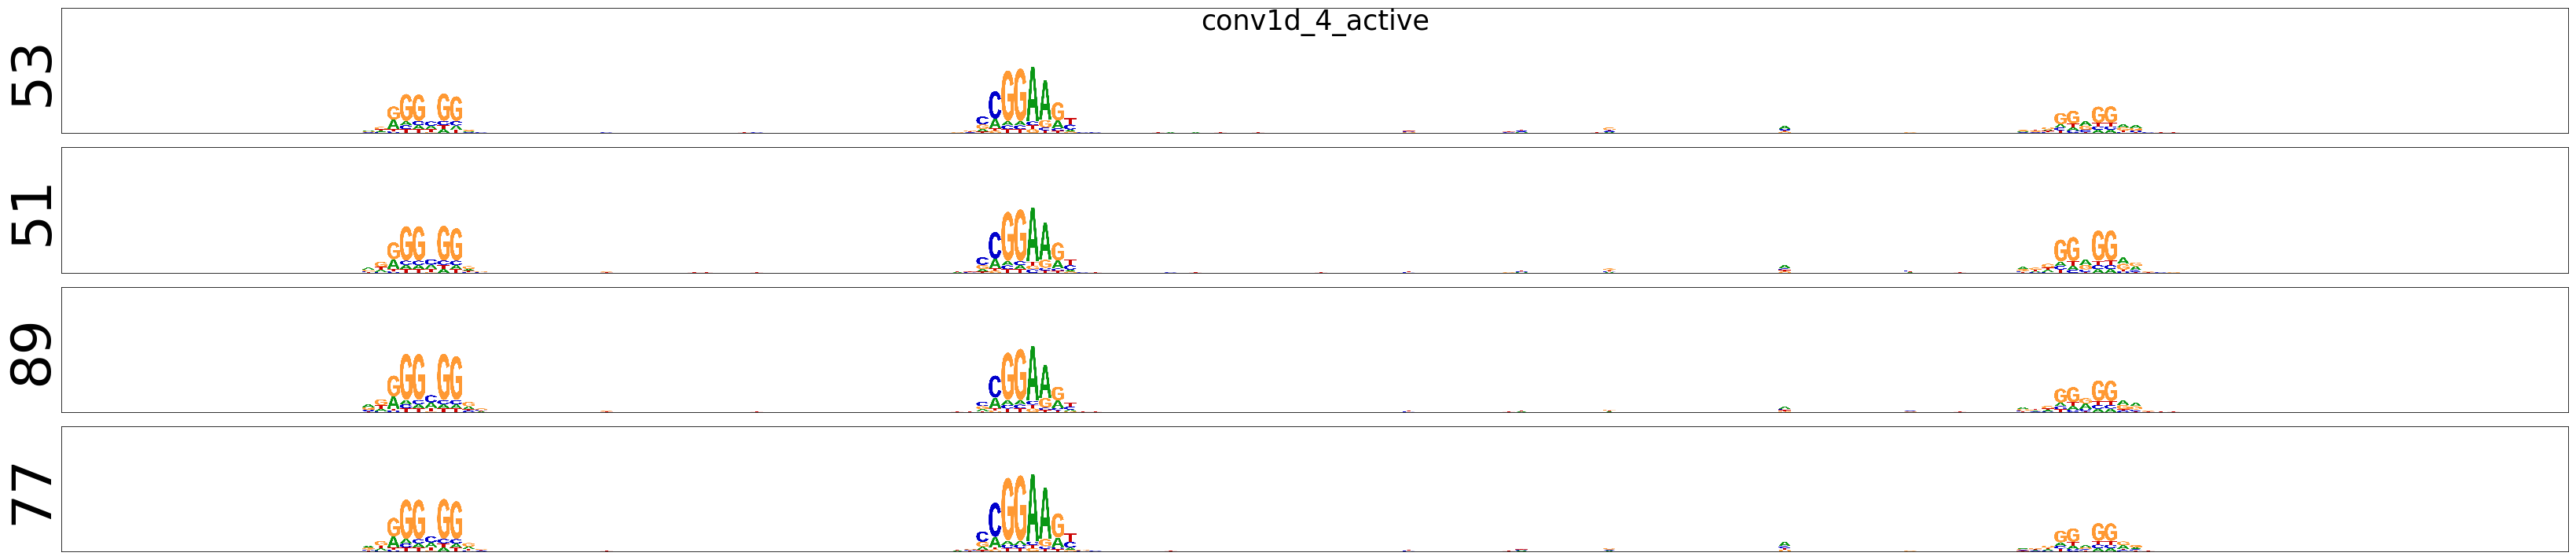

In [35]:
tf.reset_default_graph()

model_name = 'DistNet'
plot_path = utils.make_directory(plot_path, model_name)
dropout_status = True
l2_status = True
bn_status = True
    
# load model parameters
model_layers, optimization, genome_model = helper.load_model(model_name, 
                                                             input_shape, 
                                                             dropout_status, 
                                                             l2_status, 
                                                             bn_status)

# build neural network class
nnmodel = nn.NeuralNet(seed=247)
nnmodel.build_layers(model_layers, optimization, supervised=True)

# compile neural trainers
model_path = utils.make_directory(params_path, model_name)
file_path = os.path.join(model_path, model_name+'_do_l2_bn')
nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=file_path)

# initialize session
sess = utils.initialize_session()

# load best parameters
nntrainer.set_best_parameters(sess)

#load layers and neurons
dist_factors = [12, 4, 4, 4, 7]  #play around with the normfactors to get the best visuals
neuron_plot = add_normfactors(data_dist[index], normfactorlist=dist_factors)

for layer, active_indices, normfactor in neuron_plot:

    layer_dict = {'inputs': X, 'targets': np.ones((X.shape[0], 1))}
    layer_act = nntrainer.get_activations(sess, layer_dict, layer=layer)

    #For each filter what is the index of the maximally activated neuron
    max_idx = np.squeeze(np.argmax(layer_act, axis=1))

    #Identify the desired filter
    filters = active_indices

    fom_scores = []
    for filter_index in filters:
    #Get the FoM scores for each desired filter
        fom_scores.append(fom_convsal(X, layer, 'dna', filter_index, max_idx, nntrainer, sess))

    num_plots = len(filters)
    #normfactor = 5

    fig = plt.figure(figsize=(100,10))
    plt.suptitle(str(layer), fontsize=35)
    plt.subplot(num_plots,1,1)
    pwm = utils.normalize_pwm(fom_scores[0], factor=normfactor)
    logo = visualize.seq_logo(pwm, height=500, nt_width=100, norm=0, alphabet='dna')
    plt.imshow(logo)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(str(filters[0]), fontsize=70)

    plt.subplot(num_plots,1,2)
    pwm = utils.normalize_pwm(fom_scores[1], factor=normfactor)
    logo = visualize.seq_logo(pwm, height=500, nt_width=100, norm=0, alphabet='dna')
    plt.imshow(logo)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(str(filters[1]), fontsize=70)

    plt.subplot(num_plots,1,3)
    pwm = utils.normalize_pwm(fom_scores[2], factor=normfactor)
    logo = visualize.seq_logo(pwm, height=500, nt_width=100, norm=0, alphabet='dna')
    plt.imshow(logo)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(str(filters[2]), fontsize=70)

    plt.subplot(num_plots,1,4)
    pwm = utils.normalize_pwm(fom_scores[3], factor=normfactor)
    logo = visualize.seq_logo(pwm, height=500, nt_width=100, norm=0, alphabet='dna')
    plt.imshow(logo)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(str(filters[3]), fontsize=70)

# LocalNet

making directory: ../results/FoM_layers/DistNet/LocalNet/DistNet/LocalNet/DistNet/LocalNet/DistNet/LocalNet/LocalNet/DistNet/LocalNet/DistNet/LocalNet/LocalNet/LocalNet/LocalNet
loading model from:  ../results/model_params/LocalNet/LocalNet_do_l2_bn_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/model_params/LocalNet/LocalNet_do_l2_bn_best.ckpt


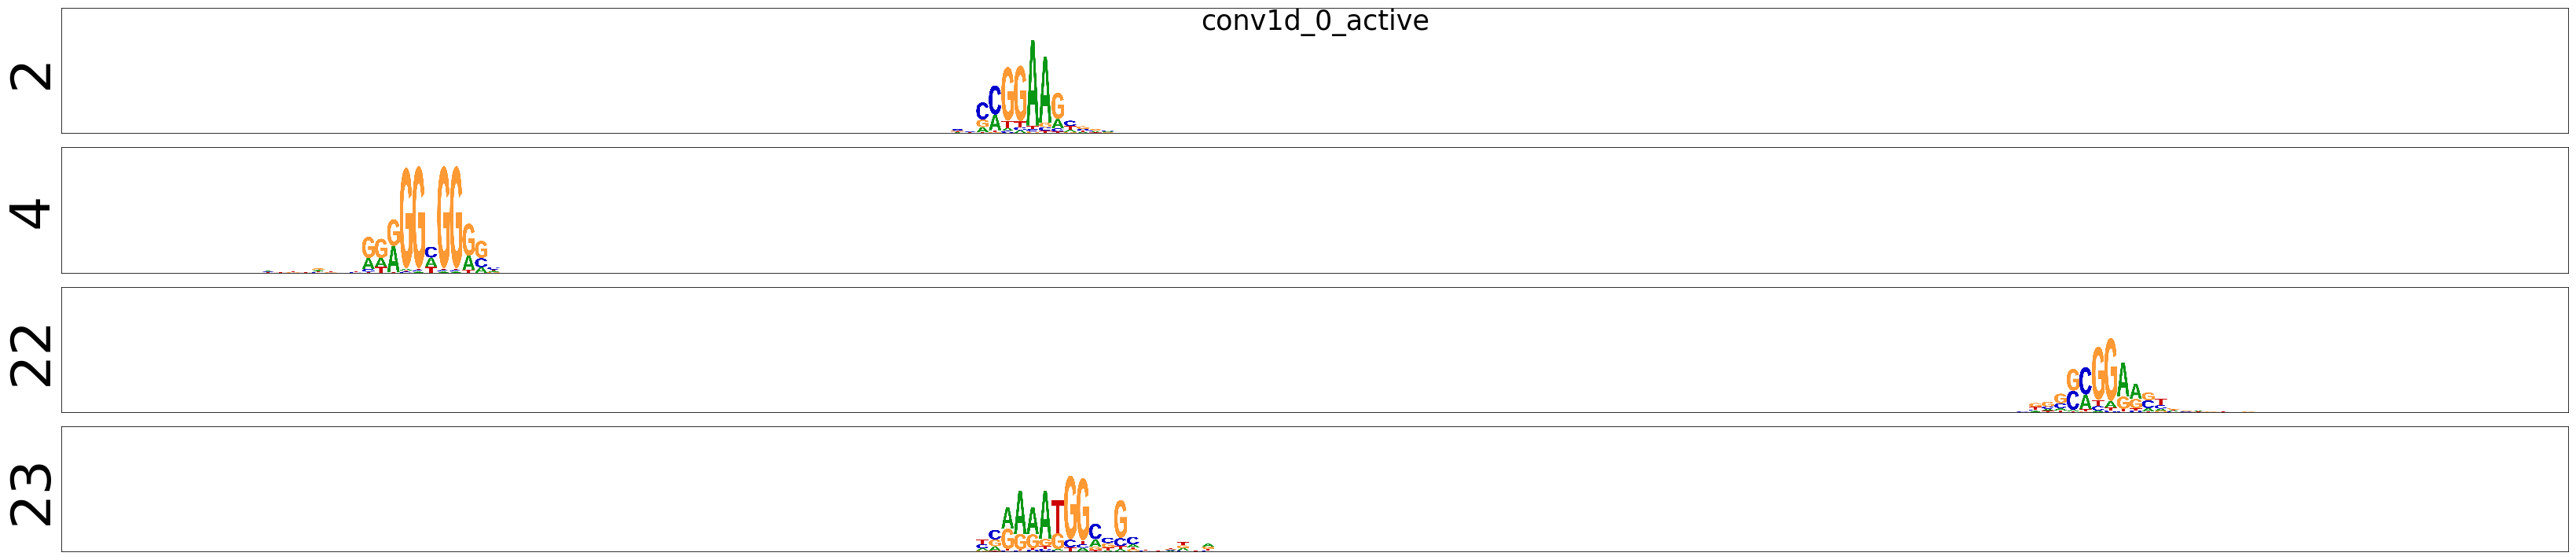

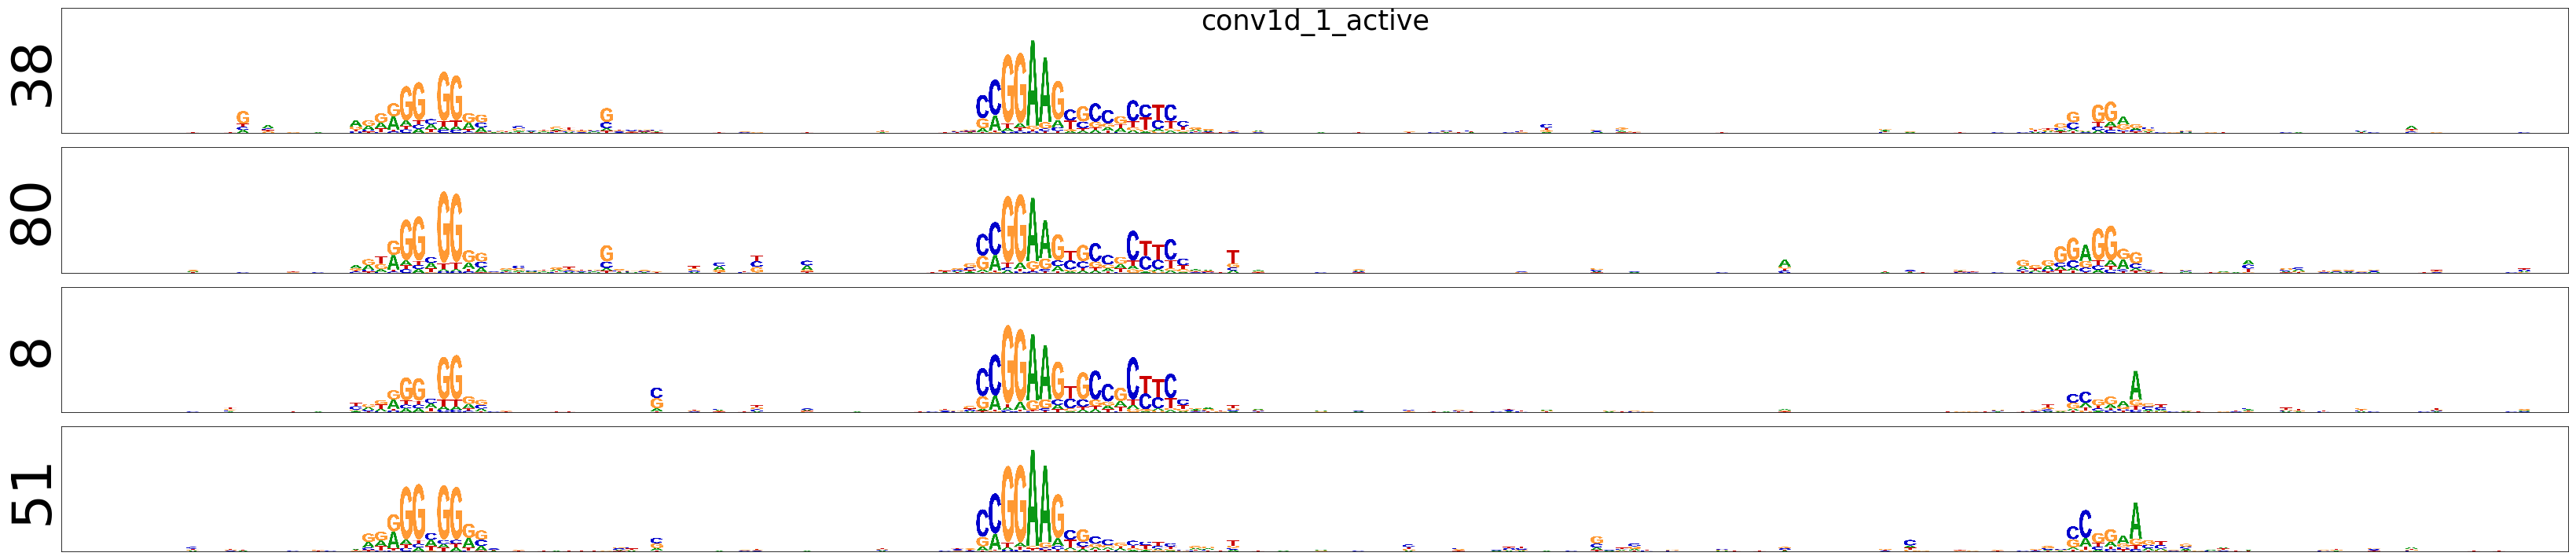

In [99]:
tf.reset_default_graph()

model_name = 'LocalNet'
plot_path = utils.make_directory(plot_path, model_name)
dropout_status = True
l2_status = True
bn_status = True
    
# load model parameters
model_layers, optimization, genome_model = helper.load_model(model_name, 
                                                             input_shape, 
                                                             dropout_status, 
                                                             l2_status, 
                                                             bn_status)

# build neural network class
nnmodel = nn.NeuralNet(seed=247)
nnmodel.build_layers(model_layers, optimization, supervised=True)

# compile neural trainers
model_path = utils.make_directory(params_path, model_name)
file_path = os.path.join(model_path, model_name+'_do_l2_bn')
nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=file_path)

# initialize session
sess = utils.initialize_session()

# load best parameters
nntrainer.set_best_parameters(sess)


#load layers and neurons
local_factors = [5,10]  #play around with the normfactors to get the best visuals
neuron_plot = add_normfactors(data_local[index], normfactorlist=local_factors)


for layer, active_indices, normfactor in neuron_plot:

    layer_dict = {'inputs': X, 'targets': np.ones((X.shape[0], 1))}
    layer_act = nntrainer.get_activations(sess, layer_dict, layer=layer)

    #For each filter what is the index of the maximally activated neuron
    max_idx = np.squeeze(np.argmax(layer_act, axis=1))

    #Identify the desired filter
    filters = active_indices

    fom_scores = []
    for filter_index in filters:
    #Get the FoM scores for each desired filter
        fom_scores.append(fom_convsal(X, layer, 'dna', filter_index, max_idx, nntrainer, sess))

    num_plots = len(filters)
    #normfactor = 5

    fig = plt.figure(figsize=(100,10))
    plt.suptitle(str(layer), fontsize=35)
    plt.subplot(num_plots,1,1)
    pwm = utils.normalize_pwm(fom_scores[0], factor=normfactor)
    logo = visualize.seq_logo(pwm, height=500, nt_width=100, norm=0, alphabet='dna')
    plt.imshow(logo)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(str(filters[0]), fontsize=70)

    plt.subplot(num_plots,1,2)
    pwm = utils.normalize_pwm(fom_scores[1], factor=normfactor)
    logo = visualize.seq_logo(pwm, height=500, nt_width=100, norm=0, alphabet='dna')
    plt.imshow(logo)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(str(filters[1]), fontsize=70)

    plt.subplot(num_plots,1,3)
    pwm = utils.normalize_pwm(fom_scores[2], factor=normfactor)
    logo = visualize.seq_logo(pwm, height=500, nt_width=100, norm=0, alphabet='dna')
    plt.imshow(logo)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(str(filters[2]), fontsize=70)

    plt.subplot(num_plots,1,4)
    pwm = utils.normalize_pwm(fom_scores[3], factor=normfactor)
    logo = visualize.seq_logo(pwm, height=500, nt_width=100, norm=0, alphabet='dna')
    plt.imshow(logo)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(str(filters[3]), fontsize=70)
    